In [16]:
# import multiprocessing as mp
# mp.set_start_method('spawn')

In [4]:
from module import APOGEEDataset
import torch
from torch.utils.data import Dataset, DataLoader
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn

import multiprocessing as mp
from multiprocessing import Process, Manager, Pool


In [6]:
try:
    mp.set_start_method('spawn')  # This should avoid issues with libraries that are not fork-safe
except RuntimeError:
    pass 

In [3]:
print(torch.get_num_threads())



16


In [4]:
directory = '../../../projects/k-pop/spectra/apogee/dr17'
dataset = APOGEEDataset(directory, max_files=500)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=8)


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        # Define the network layers
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_dim)  
        )

    def forward(self, z):
        return self.model(z)


In [ ]:
def validate_data(data):
    if torch.isnan(data).any() or torch.isinf(data).any():
        raise ValueError("Data contains NaN or Inf values")


In [6]:
# def weighted_mse_loss(output, target, mask, sigma):
#     sigma_safe = sigma + 1e-8  # to avoid division by zero
#     weights = mask / sigma_safe
#     loss = (weights * (target - output) ** 2)
#     if torch.isnan(loss).any():
#         raise ValueError("NaN detected in loss calculation")
#     return loss.sum()


In [ ]:
def weighted_min_loss(generator, z, batch, loss_func):
    """
    Calculate the weighted minimum loss for generated vs. real spectra.

    Parameters:
    generator (torch.nn.Module): The generator model of the GAN.
    z (torch.Tensor): Batch of latent vectors.
    batch (dict): Batch containing 'flux', 'sigma', 'flux_mask', etc., from the dataset.
    loss_func (function): The loss function to use (e.g., torch.nn.functional.mse_loss).

    Returns:
    torch.Tensor: The weighted minimum loss for the batch.
    """
    real_data = batch['flux']  # The real flux data
    sigma = batch['sigma']  # Standard deviations
    mask = batch['flux_mask']  # Mask for the flux

    sigma_safe = sigma**2 + 1e-8  # Prevent division by zero
    weights = mask / sigma_safe  # Compute weights

    generated_data = generator(z)  # Generate data from latent vectors
    losses = loss_func(generated_data, real_data, reduction='none')  # Calculate loss without reduction
    weighted_losses = (weights * losses).sum(dim=1)  # Apply weights and sum across each spectrum

    min_loss = weighted_losses.min()  # Get the minimum loss from the batch
    return min_loss


In [7]:
mse_loss = nn.MSELoss()

In [8]:
# Hyperparameters
latent_dim = 50
output_dim = 8575  
learning_rate_gen = 0.1
learning_rate_latent = 0.01
weight_decay = 1e-4
loss_func = torch.nn.functional.mse_loss

# Initialize the generator
generator = Generator(latent_dim, output_dim)

# Latent vectors
latent_vectors = torch.randn((len(dataset), latent_dim), requires_grad=True)

# Optimizer setup with separate learning rates
optimizer = torch.optim.Adam([
    {'params': generator.parameters(), 'lr': learning_rate_gen, 'weight_decay': weight_decay},
    {'params': latent_vectors, 'lr': learning_rate_latent}
])



Training Loop

In [9]:
import matplotlib.pyplot as plt

def plot_spectra(real, generated, epoch, index):
    plt.figure(figsize=(10, 5))
    plt.plot(real, label='Real Spectra', color='blue')
    plt.plot(generated, label='Generated Spectra', color='red', linestyle='--')
    plt.title(f'Comparison of Real and Generated Spectra at Epoch {epoch}')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.legend()
    plt.show()
    # plt.savefig(f'spectra_comparison_epoch_{epoch}_index_{index}.png')  # Save the figure
    # plt.close()

In [10]:
# num_epochs = 200  # Total number of epochs
# batch_size = 10  # Batch size for training
# loss_values = []

# # # DataLoader setup
# # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# for epoch in range(num_epochs):
#     for batch_indices, batch in dataloader:
#         optimizer.zero_grad()

       
#         real_spectra = batch['flux']  
#         mask = batch['flux_mask']
#         sigma = batch['sigma']  
#         batch_indices = batch_indices  # Custom indexing support might be needed

#         generated_spectra = generator(latent_vectors[batch_indices])
        
#         # Calculate the custom weighted loss
#         loss = weighted_mse_loss(generated_spectra, real_spectra, mask, sigma)
        
#         # loss = mse_loss(generated_spectra, real_spectra)

#         loss.backward()
#         optimizer.step()
        
#     # Store the loss value
#     loss_values.append(loss.item())
#     if epoch % 10 == 0: 
#             plot_spectra(real_spectra[0].detach().numpy(), generated_spectra[0].detach().numpy(), epoch, 0)

    
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

In [11]:
num_epochs = 200  # Total number of epochs
batch_size = 10  # Batch size for training
epoch_losses = []

In [12]:
def train_batch(batch_indices, latent_vectors, generator_state_dict, epoch_losses):
    """
    Train a single batch and update the shared dictionary with the loss.
    """
    # Setup generator
    generator = Generator(latent_dim, output_dim)
    generator.load_state_dict(generator_state_dict)

    # Setup optimizer
    optimizer = torch.optim.Adam([
        {'params': generator.parameters(), 'lr': learning_rate_gen, 'weight_decay': weight_decay},
        {'params': latent_vectors, 'lr': learning_rate_latent}
    ])
    
    # Get data from batch
    real_spectra = batch['flux']  # Assuming `batch` is globally accessible which should be adjusted
    mask = batch['flux_mask']
    sigma = batch['sigma']
    
    # Generate spectra
    generated_spectra = generator(latent_vectors[batch_indices])

    # Calculate loss
    loss = weighted_mse_loss(generated_spectra, real_spectra, mask, sigma)
    loss.backward()
    optimizer.step()

    # Record the loss for this batch
    epoch_losses.append(loss.item())


In [13]:
def init_processes(dataset, latent_vectors, generator_state_dict, num_processes, num_epochs):
    manager = Manager()
    losses_per_epoch = []
    
    # Initialize the generator in the main process
    generator = Generator(latent_dim, output_dim)
    
    for epoch in range(num_epochs):
        epoch_losses = manager.list()
        pool = Pool(processes=num_processes)

        dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=8)

        # Distribute batches to processes
        for batch_indices, batch in dataloader:
            pool.apply_async(train_batch, args=(batch_indices, latent_vectors, generator.state_dict(), epoch_losses))

        pool.close()
        pool.join()

        # Collect the last loss of the epoch for logging
        last_loss = epoch_losses[-1] if epoch_losses else float('nan')
        losses_per_epoch.append(last_loss)

        # Update generator state and possibly visualize
        generator.load_state_dict(generator_state_dict)

       if epoch % 10 == 0:
            with torch.no_grad():
                generator.eval()
                sample_latent = torch.randn(1, latent_dim).to(generator.device)  # Ensure device compatibility
                generated_spectra = generator(sample_latent).squeeze().cpu().numpy()
                real_spectra = next(iter(dataloader))['flux'][0].cpu().numpy()  # Extracting real spectra
                plot_spectra(real_spectra, generated_spectra, epoch, 0)
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {last_loss:.4f}')
            # generator.train()
        generator.train()

    return losses_per_epoch

In [14]:
def plot_spectra(real, generated, epoch, index):
    plt.figure(figsize=(10, 5))
    plt.plot(real, label='Real Spectra', color='blue')
    plt.plot(generated, label='Generated Spectra', color='red', linestyle='--')
    plt.title(f'Comparison of Real and Generated Spectra at Epoch {epoch}')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.legend()
    plt.show()

/opt/conda/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


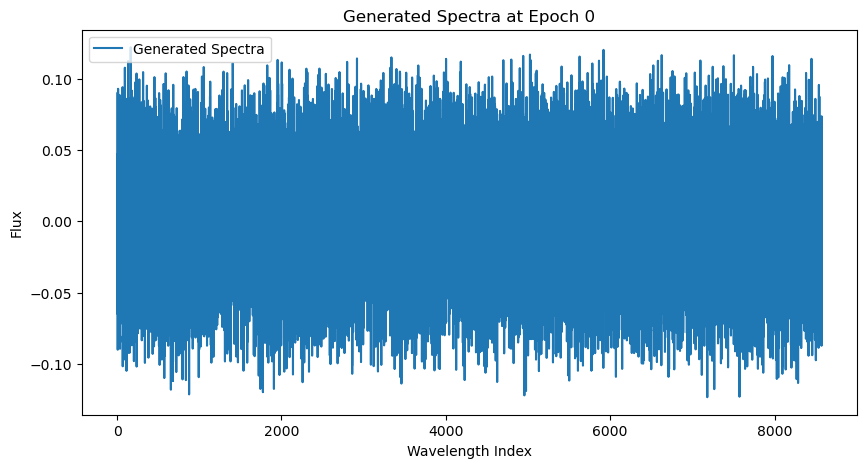

Epoch 1/200, Loss: nan


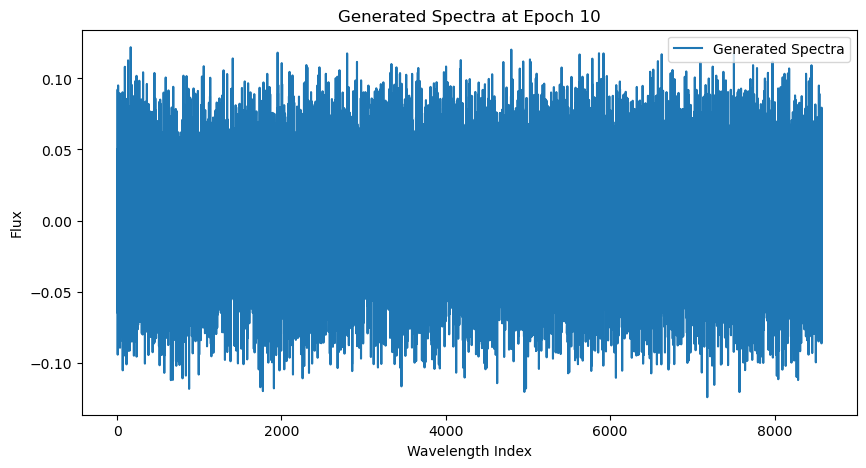

Epoch 11/200, Loss: nan


Process ForkPoolWorker-271:
Process ForkPoolWorker-275:
Process ForkPoolWorker-267:
Process ForkPoolWorker-268:
Process ForkPoolWorker-269:
Process ForkPoolWorker-266:
Process ForkPoolWorker-270:
Process ForkPoolWorker-273:
Process ForkPoolWorker-279:
Process ForkPoolWorker-277:
Process ForkPoolWorker-278:
Process ForkPoolWorker-276:
Process ForkPoolWorker-280:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in wo

KeyboardInterrupt: 

Process ForkPoolWorker-272:
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/conda/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process ForkPoolWorker-274:
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/conda/lib/python3.11/m

In [15]:
if __name__ == '__main__':
    latent_vectors = torch.randn((len(dataset), latent_dim), requires_grad=True)
    generator = Generator(latent_dim, output_dim)
    generator_state_dict = generator.state_dict()

    # Start the training across multiple processes
    loss_values = init_processes(dataset, latent_vectors, generator_state_dict, 16, 200)  # 16 processes, 200 epochs


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
